# Transfer Learning et Fine-Tuning avec BERT : Classification de Sentiments

## Objectifs de ce notebook

Dans ce notebook, nous allons tester le **Transfer Learning** et le **Fine-Tuning** en NLP avec l'architecture **BERT** :

- **Transfer Learning** - Utiliser un modèle pré-entraîné sur un language et l'adapter pour de la classification de sentiment jv
- **Fine-Tuning** - Ré-entrainer BERT à notre tâche spécifique
- **Layer Freezing** : Geler certaines couches pour le transfer learning
- **Learning Rate Scheduling** : Stratégies d'optimisation pour le fine-tuning

Utilisation du fichier nettoyé **Steam review anglais:** 'reviews_en_processed.csv' pour la classification de sentiments (positif/négatif).

## Note sur les librairies utilisées

Ce notebook utilise backend **tensorflow** avec api **KerasNLP**

La bibliothèque officielle de Keras pour le NLP, qui est **nativement compatible avec Keras 3**.

## Imports et Configuration

### Import des libraires

In [1]:
# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

import warnings
warnings.filterwarnings('ignore')

# TensorFlow et Keras
import tensorflow as tf
import keras
from keras import layers, models

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# KerasNLP pour BERT
import keras_nlp

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

2025-12-02 17:08:07.136364: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 17:08:07.356606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764691687.439829     996 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764691687.465773     996 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764691687.644977     996 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Configuration GPU

In [2]:
# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

GPU(s) détecté(s): 1 - Croissance mémoire activée


### Configuration PLOTS et SEED

In [3]:
# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

### Vérification version moteur deep learning

In [4]:
print(f"\nTensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"KerasNLP version: {keras_nlp.__version__}")


TensorFlow version: 2.19.1
Keras version: 3.11.3
KerasNLP version: 0.23.0


## Méthodes utiles

In [5]:
def column_summary(df: pd.DataFrame):
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        non_null = df[col].notna().sum()
        null_count = df[col].isna().sum()
        
        # Gérer le cas où la colonne contient des listes (unhashable)
        try:
            unique_count = df[col].nunique()
        except TypeError:
            # Si erreur (listes), convertir en string temporairement
            unique_count = df[col].astype(str).nunique()
            print(f"⚠️ Colonne '{col}' contient des types non-hashable (probablement des listes)")

        summary.append({
            'Column': col,
            'Type': str(col_type),
            'Non-Null Count': non_null,
            'Null Count': null_count,
            'Unique Values': unique_count,
        })

    # Afficher le résumé des colonnes
    print("=" * 80)
    print("Résumé détaillé des colonnes:")
    print("=" * 80)
    column_summary_df = pd.DataFrame(summary)
    print(column_summary_df.to_string(index=False))
    print("\n")

## Chargement et vérification des données des reviews anglaises (cleaned)

### Récupération kaggle hub local cache path

In [6]:
path = kagglehub.dataset_download("kieranpoc/steam-reviews")

### Chargement dataset Anglais

In [7]:
df_reviews_en = pd.read_csv(
    f"{path}/reviews_en_processed.csv",
    
    low_memory=True  # Optimize memory usage
)

### Vérification données chargé

In [8]:
df_reviews_en.head()

,voted_up,review,weighted_vote_score
0,1,Excellent!!! I love this game i cant say enoug...,0.727751
1,1,i read the entirety of moby dick in 3 days and...,0.727892
2,0,Far too much RNG. Something that won't abide i...,0.706995
3,0,"While on the face of it, a great and seemingly...",0.687157
4,1,I finally got a 94% sham. 10/10 would farm again,0.807954


In [9]:
column_summary(df_reviews_en)

Résumé détaillé des colonnes:
             Column    Type  Non-Null Count  Null Count  Unique Values
           voted_up   int64          230082           0              2
             review  object          230082           0         229159
weighted_vote_score float64          230082           0         216007




### Vérification équilibre des classes déjà en place

In [10]:
df_reviews_en["voted_up"].value_counts()

voted_up
1    115041
0    115041
Name: count, dtype: int64

### Création subset pour premiers Tests rapides

In [11]:
SUBSET_SIZE = 20000  # Utiliser 20000 reviews pour tests rapides

df_reviews_en_sample = df_reviews_en.sample(n=SUBSET_SIZE, random_state=42)

### Création Train / Val / Test

- **Train (160k)** : X_train_text + y_train  → entraîner
- **Val (20k)**    : X_val_text + y_val      → surveiller l'entraînement
- **Test (20k)**   : X_test_text + y_test    → évaluation finale

In [12]:
# Premier split : 80% train+val, 20% test
X_temp, X_test_text, y_temp, y_test = train_test_split(
    df_reviews_en_sample['review'],
    df_reviews_en_sample['voted_up'],
    test_size=0.2,
    stratify=df_reviews_en_sample['voted_up'],
    random_state=42
)

# Deuxième split : 80% train, 20% val (du temp)
# Ça donne au final : 64% train, 16% val, 20% test
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.2,  # 20% du temp = 16% du total
    stratify=y_temp,
    random_state=42
)

X_train_text:pd.Series
y_train:pd.Series

X_val_text:pd.Series
y_val:pd.Series

X_test_text:pd.Series
y_test:pd.Series

X_train_text = X_train_text.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val_text = X_val_text.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test_text = X_test_text.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Vérification train / val / test

In [13]:
# Vérifier les proportions
print(f"Train: {len(X_train_text)} ({len(X_train_text)/len(df_reviews_en_sample)*100:.1f}%)")
print(f"Val:   {len(X_val_text)} ({len(X_val_text)/len(df_reviews_en_sample)*100:.1f}%)")
print(f"Test:  {len(X_test_text)} ({len(X_test_text)/len(df_reviews_en_sample)*100:.1f}%)")

print("\nDistribution train:", y_train.value_counts(normalize=True))
print("\nDistribution val:", y_val.value_counts(normalize=True))
print("\nDistribution test:", y_test.value_counts(normalize=True))

# Statistiques de longueur de texte
train_lengths = [len(text.split()) for text in X_train_text]
print(f"\nLongueur moyenne des reviews train: {np.mean(train_lengths):.0f} mots")

val_lengths = [len(text.split()) for text in X_val_text]
print(f"\nLongueur moyenne des reviews val: {np.mean(val_lengths):.0f} mots")

test_lengths = [len(text.split()) for text in X_test_text]
print(f"\nLongueur moyenne des reviews test: {np.mean(test_lengths):.0f} mots")

Train: 12800 (64.0%)
Val:   3200 (16.0%)
Test:  4000 (20.0%)

Distribution train: voted_up
1    0.503281
0    0.496719
Name: proportion, dtype: float64

Distribution val: voted_up
1    0.503125
0    0.496875
Name: proportion, dtype: float64

Distribution test: voted_up
1    0.50325
0    0.49675
Name: proportion, dtype: float64

Longueur moyenne des reviews train: 116 mots

Longueur moyenne des reviews val: 116 mots

Longueur moyenne des reviews test: 116 mots


### Graphiques vérification longueur et distribution

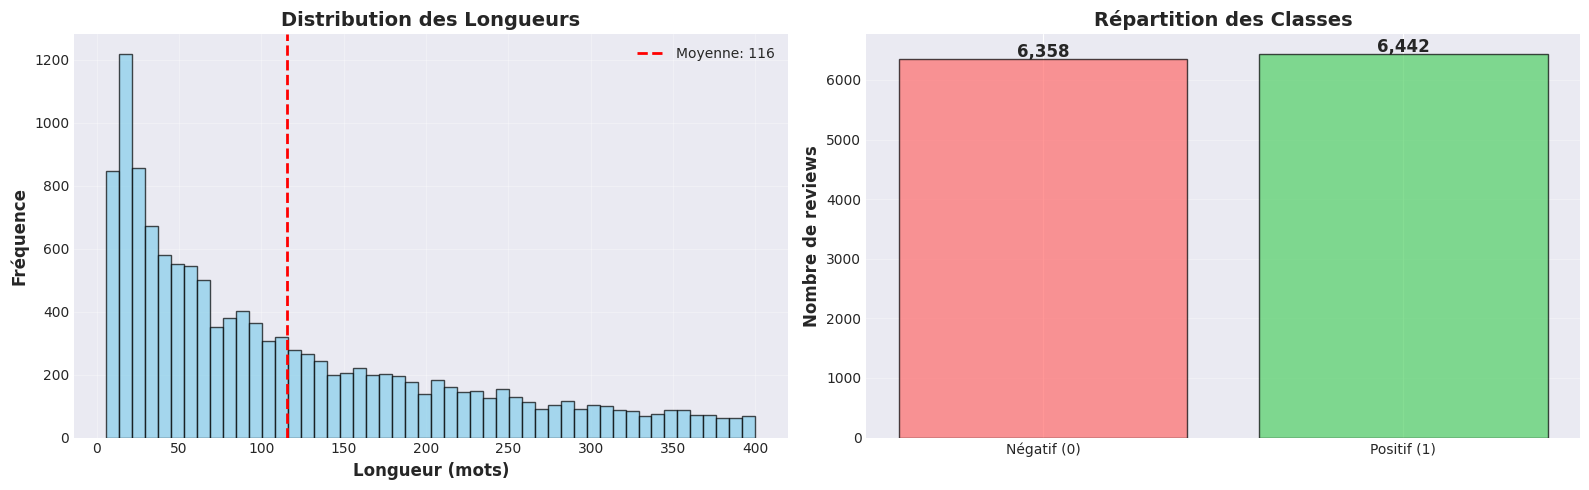

In [14]:
# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1 : plt.Axes
# Distribution des longueurs
ax1.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(np.mean(train_lengths), color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne: {np.mean(train_lengths):.0f}')
ax1.set_xlabel('Longueur (mots)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des Longueurs', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Distribution des classes
labels = ['Négatif (0)', 'Positif (1)']
counts = [np.sum(y_train == 0), np.sum(y_train == 1)]
colors = ['#ff6b6b', '#51cf66']

ax2 : plt.Axes
ax2.bar(labels, counts, color=colors, edgecolor='black', alpha=0.7)
ax2.set_ylabel('Nombre de reviews', fontsize=12, fontweight='bold')
ax2.set_title('Répartition des Classes', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

for i, (label, count) in enumerate(zip(labels, counts)):
    ax2.text(i, count + 20, f'{count:,}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Exemples de Reviews

In [15]:
pos_indices = np.where(y_train == 1)[0][:2]
neg_indices = np.where(y_train == 0)[0][:2]

for idx in list(pos_indices) + list(neg_indices):
    review = X_train_text[idx]
    sentiment = "✅ POSITIF" if y_train[idx] == 1 else "❌ NÉGATIF"
    
    print(f"\n{sentiment}")
    print("-" * 80)
    print(review[:500] + "..." if len(review) > 500 else review)
    print(f"\nLongueur: {len(review.split())} mots")


✅ POSITIF
--------------------------------------------------------------------------------
Pretty decent gameplay loop and deserves more attention. I definitely recommend it for anyone who enjoys roguelikes or stealth games

Longueur: 20 mots

✅ POSITIF
--------------------------------------------------------------------------------
Battlerite is what I call a well done game. The f2p launch was really successful and with 40k players the game is really enjoyable. SLS made a game that was missing in the f2p list, 2v2 arena with fast gameplay and lots of strategy and skillshots. The learning curve is of course really high at the beginning of your experience, as the game is really fast it's harder to learn the first few times you'll play. Also for those who like fashion-gaming there are some sick outfits and weapons and those a...

Longueur: 167 mots

❌ NÉGATIF
--------------------------------------------------------------------------------
What I achieved today in PUBG: - 4 or 5 times. O

## BERT Base avec KerasNLP

**KerasNLP** est la bibliothèque officielle de Keras pour le NLP :
- Nativement compatible avec Keras 3
- API simple et cohérente
- Preprocessing intégré
- Modèles pré-entraînés (BERT, GPT, etc.)
- Optimisé pour les performances

**BertBase** a été entrainer sur de l'anglais uniquement

### Préparation BERT preprocessor

In [ ]:
# Utiliser le preprocesseur BERT pré-entraîné
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_small_en_uncased",  # Version légère pour la présentation
    sequence_length=128
)

print("Preprocesseur chargé")

Preprocesseur chargé


I0000 00:00:1764691694.120860     996 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9515 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


### Test du preprocesseur

In [17]:
print(f"\nVocabulaire: {preprocessor.tokenizer.vocabulary_size():,} tokens")

test_text = "This movie was absolutely fantastic!"
preprocessed = preprocessor([test_text])

print(f"\nTest du preprocesseur:")

print(f"\nTexte original: '{test_text}'")
print(f"\nClés disponibles: {list(preprocessed.keys())}")
print(f"\ntoken_ids shape: {preprocessed['token_ids'].shape}")
print(f"segment_ids shape: {preprocessed['segment_ids'].shape}")
print(f"padding_mask shape: {preprocessed['padding_mask'].shape}")


Vocabulaire: 30,522 tokens

Test du preprocesseur:

Texte original: 'This movie was absolutely fantastic!'

Clés disponibles: ['token_ids', 'padding_mask', 'segment_ids']

token_ids shape: (1, 128)
segment_ids shape: (1, 128)
padding_mask shape: (1, 128)


2025-12-02 17:08:14.247075: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


### Preprocessing des données Train / Val / Test

In [ ]:
# On réalise le preprocessing en amont de l'entrainement pour éviter de la faire à chaque epochs

# Préprocesser les données
X_train_bert = preprocessor(X_train_text)
X_val_bert = preprocessor(X_val_text)
X_test_bert = preprocessor(X_test_text)

print("Preprocessing terminé")

# Preprocessing au moment de la création du modèle bert:
# Construction du modèle
# inputs = keras.Input(shape=(), dtype="string", name="text_input")

# # Prétraitement
# x = preprocessor(inputs)

# # Backbone BERT
# x = bert_backbone(x)

NameError: name 'preprocessor' is not defined

## Fine-Tuning BERT

### Approche 1 : Feature Extraction (BERT Gelé)

#### Création du modèle Feature Extraction

Crée un modèle BERT avec les poids gelés (Feature Extraction).

In [ ]:
def instantiate_bert_model_frozen():
    
    # Charger BERT pré-entraîné from preset
    bert_backbone = keras_nlp.models.BertBackbone.from_preset(
        "bert_small_en_uncased",  # Version légère
        trainable=False  # GELÉ
    )
    
    # Input
    inputs = {
        "token_ids": layers.Input(shape=(128,), dtype=tf.int32, name="token_ids"),
        "segment_ids": layers.Input(shape=(128,), dtype=tf.int32, name="segment_ids"),
        "padding_mask": layers.Input(shape=(128,), dtype=tf.int32, name="padding_mask"),
    }
    
    # BERT Encoder
    bert_output = bert_backbone(inputs)["sequence_output"]
    
    # Prendre le [CLS] token (première position)
    cls_token = bert_output[:, 0, :]
    
    # Couches de classification
    x = layers.Dropout(0.3)(cls_token)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid', name='classifier')(x)
    
    model = keras.Model(inputs, output)
    
    return model, bert_backbone

In [ ]:
# Créer le modèle
print("Création du modèle BERT (Feature Extraction)...\n")
bert_frozen_model, bert_backbone = instantiate_bert_model_frozen()

LEARNING_RATE_FEATURE_EXTRACT_BERT_BASE = 1e-3 # ou 1e-4
# BERT est complètement freezé (ses poids ne bougent pas)
# Seules les couches denses finales s'entraînent, plus gros pas pour converger rapidement

# Compiler
bert_frozen_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE_FEATURE_EXTRACT_BERT_BASE), # Adam as usual et learning rate plus élevé car BERT gelé
    loss='binary_crossentropy', # Fonction de perte pour classification binaire (0 ou 1)
    metrics=['accuracy'] # Pourcentage de prédictions correctes
)

Création du modèle BERT (Feature Extraction)...



### Vérification modèle 

In [21]:
bert_frozen_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 512),     │ 28,763,648 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, 128, 512)] │            │ segment_ids[0][0… │
│                     │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 512)       │          0 │ bert_backbone[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     32,832 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,796,545 (109.85 MB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 28,763,648 (109.72 MB)

#### Paramétrage Callbacks Feature extraction

In [22]:
# Callbacks

# Early Stopping
early_stop_bert_frozen = EarlyStopping(
    monitor='val_loss',          # Métrique à surveiller
    patience=3,                  # Nombre d'epochs à attendre, plus de patience que finetuning car converge plus vite
    restore_best_weights=True,   # Restaurer les meilleurs poids
    verbose=1,                   # Affiche quand ça s'arrête
)

# Learning rate scheduling
reduce_lr_bert_frozen = ReduceLROnPlateau(
    monitor='val_loss',  # Surveille la loss de validation
    factor=0.5,          # Multiplie le LR par 0.5 quand ça stagne
    patience=2,          # Attend 2 epochs avant de réduire (test avec 1)
    min_lr=1e-7,         # LR minimum (test 1e-6 ne descend pas en dessous)
    verbose=1
)

#### Lancement de l'Entrainement Feature Extraction

In [23]:
# Entraînement
print("\n Entraînement BERT (Feature Extraction)...\n")

BATCH_SIZE_FEATURE_EXTRACT_BERT_BASE = 32 # Traite 32 reviews à la fois
# 32 Bon équilibre
# 8 - 16 Plus stable, meilleures généralisations (plus de RAM)
# 64-128 Plus rapide, moins stable, risque d'overfitting

EPOCHS_FEATURE_EXTRACT_BERT_BASE = 10
# Avec EarlyStopping, ex: si ça stagne à epoch 4, l'entraînement s'arrête. 
# Attention overfitting possible si trop d'epochs


history_bert_frozen = bert_frozen_model.fit(
    X_train_bert,
    y_train,
    validation_data=(X_val_bert, y_val),
    epochs=EPOCHS_FEATURE_EXTRACT_BERT_BASE,
    batch_size=BATCH_SIZE_FEATURE_EXTRACT_BERT_BASE,
    callbacks=[early_stop_bert_frozen, reduce_lr_bert_frozen],
    verbose=1
)

print("\n Entraînement BERT (frozen) terminé !")


 Entraînement BERT (Feature Extraction)...

Epoch 1/10


I0000 00:00:1764691697.936736    9870 service.cc:152] XLA service 0x755c7c0078a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764691697.936773    9870 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-12-02 17:08:18.035313: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764691698.440788    9870 cuda_dnn.cc:529] Loaded cuDNN version 91400
2025-12-02 17:08:19.888419: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 240 bytes spill stores, 240 bytes spill loads

2025-12-02 17:08:20.123993: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot

  4/400 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.4935 - loss: 0.9714

I0000 00:00:1764691702.546920    9870 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7014 - loss: 0.5754 - val_accuracy: 0.7772 - val_loss: 0.4772 - learning_rate: 0.0010
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7452 - loss: 0.5192 - val_accuracy: 0.7803 - val_loss: 0.4694 - learning_rate: 0.0010
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7520 - loss: 0.5089 - val_accuracy: 0.7884 - val_loss: 0.4543 - learning_rate: 0.0010
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7561 - loss: 0.4998 - val_accuracy: 0.7906 - val_loss: 0.4510 - learning_rate: 0.0010
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7648 - loss: 0.4960 - val_accuracy: 0.7925 - val_loss: 0.4494 - learning_rate: 0.0010
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7654 - loss: 0.4924 - val_accuracy: 0.7962 - val_loss: 0.4477 - learning_rate: 0.0010
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7657 - loss: 0.4922 - val

### Approche 2 : Fine-Tuning Complet

#### Créer et compiler le modèle finetuning

Crée un modèle BERT avec fine-tuning complet, on dégèle les couches cachées

In [ ]:
def instantiate_bert_model_finetuned(preset_name: str, architecture_layer=0):

    # BERT backbone - TOUS LES POIDS ENTRAÎNABLES
    bert_backbone = keras_nlp.models.BertBackbone.from_preset(
        preset_name, trainable=True  # FINE-TUNING
    )

    # Inputs (données déjà preprocessée en amont)
    inputs = {
        "token_ids": layers.Input(shape=(128,), dtype=tf.int32, name="token_ids"),
        "segment_ids": layers.Input(shape=(128,), dtype=tf.int32, name="segment_ids"),
        "padding_mask": layers.Input(shape=(128,), dtype=tf.int32, name="padding_mask"),
    }

    # Construction du modèle avec preprocess intégré mais à chaque epochs
    # inputs = keras.Input(shape=(), dtype="string", name="text_input")
    # x = preprocessor(inputs)

    # BERT
    bert_output = bert_backbone(inputs)["sequence_output"]
    # x = bert_backbone(x) sequence_output sortie par défaut

    # Extraction du token [CLS] (premier token)
    cls_token = bert_output[:, 0, :]

    if (
        architecture_layer == 1
    ):  # Architecture vu pendant la formation avec petit dataset de démo
        x = layers.Dropout(0.3)(cls_token)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dropout(0.3)(x)
    elif architecture_layer == 2:  # Architecture plus équilibré
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dropout(0.2)(x)
    elif architecture_layer == 3:  # Architecture plus complexe
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dropout(0.3)(x)
    else:
        x = layers.Dropout(0.1)(x)

    # TODO Nombre de couches Version auto avec optuna
    # study = optuna.create_study(direction="maximize")
    # study.optimize(objective, n_trials=100)

    # Dernière couche commune pour la classification
    output = layers.Dense(1, activation="sigmoid", name="classifier")(x)
    model = keras.Model(inputs, output)

    return model

In [ ]:
# Créer le modèle
print("Création du modèle BERT (Fine-Tuning)\n")

# "bert_tiny_en_uncased",
bert_finetuned_model = instantiate_bert_model_finetuned("bert_tiny_en_uncased",1)

LEARNING_RATE_FINETUNING_BERT_BASE = 2e-5
# Très petit car BERT est déjà pré-entraîné
# Valeurs typiques BERT Fintuning = 2e-5, 3e-5, 5e-5
# Grand LR (0.01) = grands pas → rapide mais risque de tout oublier
# Petit LR (2e-5) = petits pas → lent mais précis

bert_finetuned_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE_FINETUNING_BERT_BASE), # Adam = Algorithme d'optimisation adaptatif
    loss='binary_crossentropy', # Fonction de perte pour classification binaire (0 ou 1)
    metrics=['accuracy'] # Pourcentage de prédictions correctes
)

Création du modèle BERT (Fine-Tuning)



#### Paramétrage Callbacks Finetuning

In [26]:
# Callbacks

# Early Stopping
early_stop_bert =EarlyStopping(
    monitor='val_loss',          # Métrique à surveiller
    patience=2,                  # Nombre d'epochs à attendre
    restore_best_weights=True,   # Restaurer les meilleurs poids
    verbose=1,                   # Affiche quand ça s'arrête
    mode='min',                  # 'min' pour loss, 'max' pour accuracy
    min_delta=0.001              # Amélioration minimale requise
)

# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Surveille la loss de validation
    factor=0.5,          # Multiplie le LR par 0.5 quand ça stagne
    patience=1,          # Attend 1 epoch avant de réduire (test avec 2)
    min_lr=1e-7,         # LR minimum (ne descend pas en dessous)
    verbose=1
)

#### Lancement de l'entrainement Finetuning

In [27]:
print("\nFine-Tuning BERT...\n")

BATCH_SIZE_FINETUNING_BERT_BASE = 32 # Traite 32 reviews à la fois
# 32 Bon équilibre
# 8 - 16 Plus stable, meilleures généralisations (plus de RAM)
# 64-128 Plus rapide, moins stable, risque d'overfitting

EPOCHS_FINETUNING_BERT_BASE = 10
# Avec EarlyStopping, ex: si ça stagne à epoch 4, l'entraînement s'arrête. 
# Attention overfitting possible si trop d'epochs

history_bert_finetuned = bert_finetuned_model.fit(
    X_train_bert,
    y_train,
    validation_data=(X_val_bert, y_val),
    epochs=EPOCHS_FINETUNING_BERT_BASE,
    batch_size=BATCH_SIZE_FINETUNING_BERT_BASE,
    callbacks=[early_stop_bert, reduce_lr],
    verbose=1
)

print("\nFine-Tuning BERT terminé")


Fine-Tuning BERT...

Epoch 1/10


2025-12-02 17:09:06.972479: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_50_0', 52 bytes spill stores, 52 bytes spill loads

2025-12-02 17:09:06.983257: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_50', 432 bytes spill stores, 336 bytes spill loads

2025-12-02 17:09:06.985764: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_50', 424 bytes spill stores, 352 bytes spill loads

2025-12-02 17:09:07.195440: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 16 bytes spill stores, 16 bytes spill loads

2025-12-02 17:09:07.247043: I external/loc

400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.5721 - loss: 0.7227 - val_accuracy: 0.6847 - val_loss: 0.5936 - learning_rate: 2.0000e-05
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6567 - loss: 0.6235 - val_accuracy: 0.7122 - val_loss: 0.5480 - learning_rate: 2.0000e-05
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ -0s -88us/step - accuracy: 0.7178 - loss: 0.5588 - val_accuracy: 0.7572 - val_loss: 0.5029 - learning_rate: 2.0000e-05
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7569 - loss: 0.5070 - val_accuracy: 0.7619 - val_loss: 0.4933 - learning_rate: 2.0000e-05
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7885 - loss: 0.4631 - val_accuracy: 0.7850 - val_loss: 0.4616 - learning_rate: 2.0000e-05
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8069 - loss: 0.4309 - val_accuracy: 0.8016 - val_loss: 0.4443 - learning_rate: 2.0000e-05
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8249 

## Comparaison des Modèles

### Loss / Accuracy

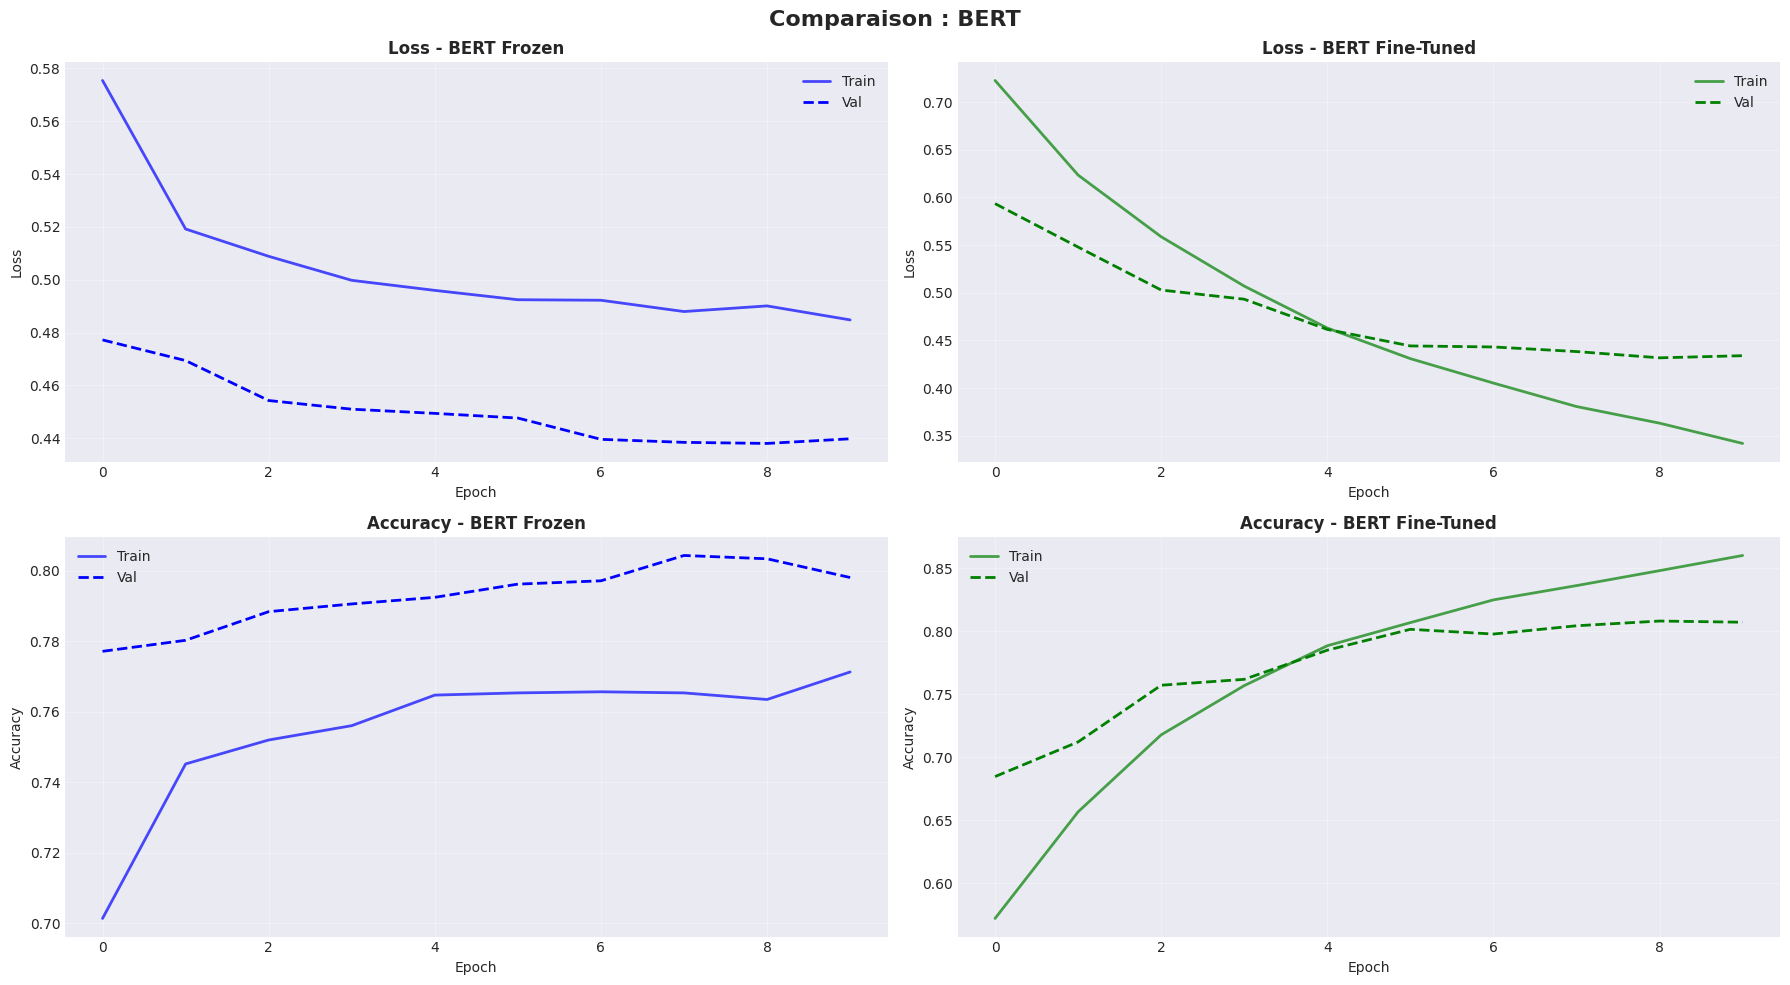

In [28]:
models_histories = [
    ('BERT Frozen', history_bert_frozen, 'blue'),
    ('BERT Fine-Tuned', history_bert_finetuned, 'green')
]

# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Comparaison : BERT', fontsize=16, fontweight='bold')

# Loss
for idx, (name, history, color) in enumerate(models_histories):
    ax = axes[0, idx]
    ax : plt.Axes
    ax.plot(history.history['loss'], label='Train', linewidth=2, color=color, alpha=0.7)
    ax.plot(history.history['val_loss'], label='Val', linewidth=2, color=color, linestyle='--')
    ax.set_title(f'Loss - {name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(alpha=0.3)

# Accuracy
for idx, (name, history, color) in enumerate(models_histories):
    ax = axes[1, idx]
    ax : plt.Axes
    ax.plot(history.history['accuracy'], label='Train', linewidth=2, color=color, alpha=0.7)
    ax.plot(history.history['val_accuracy'], label='Val', linewidth=2, color=color, linestyle='--')
    ax.set_title(f'Accuracy - {name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Évaluation Finale

In [29]:
# BERT Frozen
bert_frozen_test_loss, bert_frozen_test_acc = bert_frozen_model.evaluate(X_test_bert, y_test, verbose=0)
y_pred_bert_frozen = (bert_frozen_model.predict(X_test_bert, verbose=0) > 0.5).astype(int).flatten()

# BERT Fine-Tuned
bert_ft_test_loss, bert_ft_test_acc = bert_finetuned_model.evaluate(X_test_bert, y_test, verbose=0)
y_pred_bert_ft = (bert_finetuned_model.predict(X_test_bert, verbose=0) > 0.5).astype(int).flatten()

# Tableau comparatif
results_df = pd.DataFrame({
    'Modèle': ['BERT Frozen', 'BERT Fine-Tuned'],
    'Test Loss': [bert_frozen_test_loss, bert_ft_test_loss],
    'Test Accuracy': [bert_frozen_test_acc, bert_ft_test_acc],
})

print("\n")
print(results_df.to_string(index=False))
print("\n" + "=" * 80)

best_idx = results_df['Test Accuracy'].idxmax()
print(f"\n🏆 MEILLEUR: {results_df.loc[best_idx, 'Modèle']} - {results_df.loc[best_idx, 'Test Accuracy']*100:.2f}%")



         Modèle  Test Loss  Test Accuracy
    BERT Frozen   0.446150        0.79575
BERT Fine-Tuned   0.424308        0.81700


🏆 MEILLEUR: BERT Fine-Tuned - 81.70%


### Matrices de Confusion

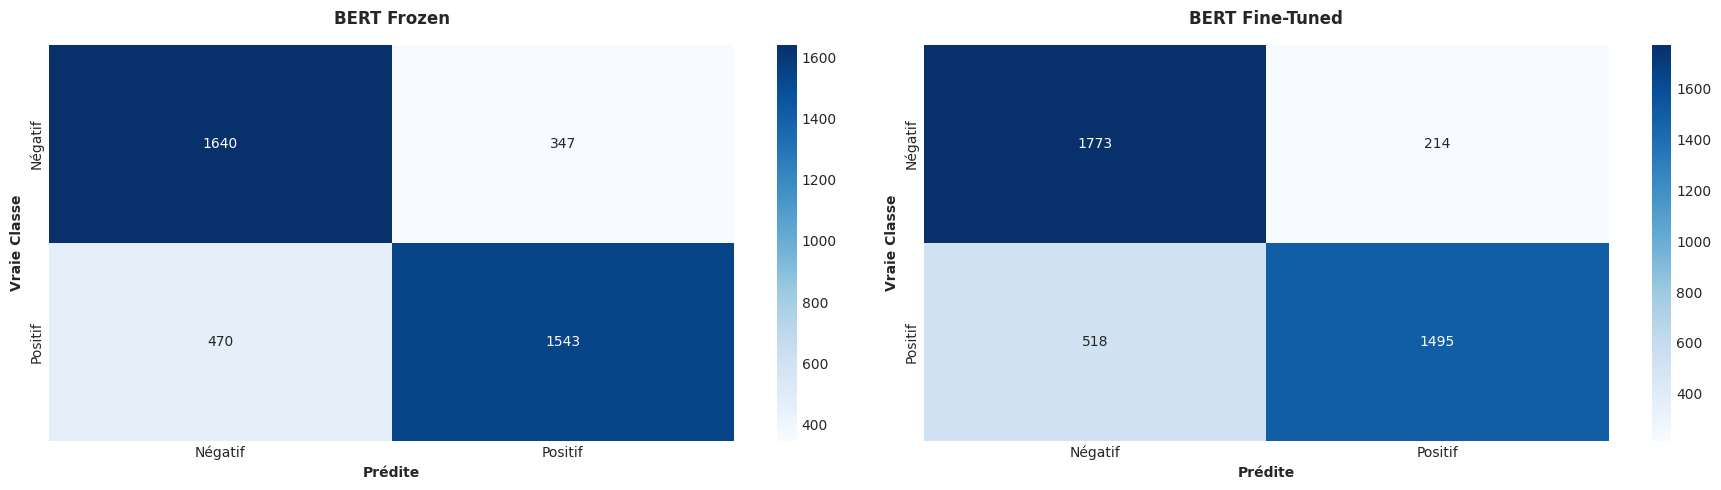

In [30]:
# Matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

predictions = [
    ('BERT Frozen', y_pred_bert_frozen),
    ('BERT Fine-Tuned', y_pred_bert_ft)
]

for idx, (name, y_pred) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Négatif', 'Positif'],
                yticklabels=['Négatif', 'Positif'])
    
    ax = axes[idx]
    ax : plt.Axes
    
    ax.set_title(f'{name}', fontsize=12, fontweight='bold', pad=15)
    ax.set_ylabel('Vraie Classe', fontweight='bold')
    ax.set_xlabel('Prédite', fontweight='bold')

plt.tight_layout()
plt.show()

### Classification reports

In [31]:
# Reports détaillés
for name, y_pred in predictions:
    print(f"\n{name}:")
    print("-" * 80)
    print(classification_report(y_test, y_pred, target_names=['Négatif', 'Positif']))


BERT Frozen:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     Négatif       0.78      0.83      0.80      1987
     Positif       0.82      0.77      0.79      2013

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000


BERT Fine-Tuned:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     Négatif       0.77      0.89      0.83      1987
     Positif       0.87      0.74      0.80      2013

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



## Tests sur Nouvelles Reviews

### Création de reviews de tests rapide synthetique

In [32]:
# Reviews de test
test_reviews = [
    "This game was absolutely amazing! The graphics and gameplay was superb.",
    "Terrible game. Waste of time and money. The worst game ever.",
    "It was okay, nothing special. Some good moments but forgettable.",
    "Brilliant masterpiece! One of the best games of the decade!",
    "Boring and predictable. The actors tried but the script was awful.",
    "I loved every minute! The graphics were stunning."
]

### Preprocessor sur test_reviews

In [33]:
test_preprocessed = preprocessor(test_reviews)

### Prediction à partir du modèle fine tuned

In [34]:
predictions_prob = bert_finetuned_model.predict(test_preprocessed, verbose=0).flatten()

2025-12-02 17:09:42.500607: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 432 bytes spill stores, 336 bytes spill loads

2025-12-02 17:09:42.543081: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 232 bytes spill stores, 232 bytes spill loads

2025-12-02 17:09:42.582894: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 388 bytes spill stores, 388 bytes spill loads

2025-12-02 17:09:42.761771: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 424 bytes spill stores, 352 bytes spill loads



### Résultats

In [35]:
for i, (review, prob) in enumerate(zip(test_reviews, predictions_prob), 1):
    
    sentiment = "POSITIF" if prob > 0.5 else "NÉGATIF" #sentiment prediction
    confidence = prob if prob > 0.5 else 1 - prob #confidence score
    
    emoji = "✅" if sentiment == "POSITIF" else "❌"
    
    print(f"\n{i}. \"{review}\"")
    print(f"   {emoji} {sentiment} (Confiance: {confidence*100:.1f}%)")
    print("-" * 90)


1. "This game was absolutely amazing! The graphics and gameplay was superb."
   ✅ POSITIF (Confiance: 96.3%)
------------------------------------------------------------------------------------------

2. "Terrible game. Waste of time and money. The worst game ever."
   ❌ NÉGATIF (Confiance: 98.6%)
------------------------------------------------------------------------------------------

3. "It was okay, nothing special. Some good moments but forgettable."
   ❌ NÉGATIF (Confiance: 71.7%)
------------------------------------------------------------------------------------------

4. "Brilliant masterpiece! One of the best games of the decade!"
   ✅ POSITIF (Confiance: 99.7%)
------------------------------------------------------------------------------------------

5. "Boring and predictable. The actors tried but the script was awful."
   ❌ NÉGATIF (Confiance: 99.0%)
------------------------------------------------------------------------------------------

6. "I loved every minute! The

## Exporter un premier modèle

In [ ]:
# Sauvegarder le modèle finetuned
bert_finetuned_model.save("../outputs/models/poc/bert_base_model_ipynb.keras")

# On ne sauvegarde pas le preprocessor car on ne peut pas le sauvegarder avec keras
# Il faut le recréer à partir de la config
# preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
#     "bert_small_en_uncased",
#     sequence_length=128
# )

## Aller Plus Loin avec KerasNLP

#### BERT Variants

- bert_tiny_en_uncased: Léger (démo, tests rapides)
- bert_small_en_uncased: Petit (bon compromis)
- bert_base_en_uncased: Base standard (110M params)
- bert_large_en_uncased: Large (340M params, meilleur)

#### Autres Modèles

- RoBERTa: roberta_base_en, roberta_large_en
- DistilBERT: distil_bert_base_en_uncased
- ALBERT: albert_base_en_uncased

#### Keras NLP

- preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en_uncased")
- backbone = keras_nlp.models.BertBackbone.from_preset("bert_base_en_uncased")

## Conclusion

Dans ce notebook, nous avons exploré :

1. **Transfer Learning** avec BERT
2. **KerasNLP** : Solution officielle Keras 3
3. **Feature Extraction** vs **Fine-Tuning**
5. **API Simple** et unifiée

### Points Clés

- **KerasNLP** est nativement compatible avec Keras 3
- API simple : `from_preset()` pour tout
- Preprocessing automatique intégré